In [ ]:
import tensorflow as tf
print(tf.__version__)

2.17.0
True


In [ ]:
# API FUNCIONAL
import keras
from keras import layers
# capa de entrada
inputs = keras.Input(shape=(3,)) # cada SAMPLE es de la forma (3,), por ejemplo [1,2,3]
features = layers.Dense(63, activation="relu")(inputs) # es como una función cuyos argumentos son la capa anterior
outputs = layers.Dense(10, activation="softmax")(features)
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
# si tengo 3 inputs (title, body y tags) y 2 outputs (priority, department) cada una con su f activación:
vocabulary_size = 10000
num_tags = 100
num_departments = 4

title = keras.Input(shape=(vocabulary_size,), name="title")
text_body = keras.Input(shape=(vocabulary_size,), name="text_body")
tags = keras.Input(shape=(num_tags,), name="tags")
# concateno las 3 capas de entrada como si fueran una sola
features = layers.Concatenate()([title, text_body, tags])
features = layers.Dense(64, activation="relu")(features) # la capa intermedia tiene el mismo nombre
# cada una de las 2 capas de output reciben el tensor que es la capa oculta "features"
priority = layers.Dense(1, activation="sigmoid", name="priority")(features)
department = layers.Dense(num_departments, activation="softmax", name="department")(features)
# 3 inputs y 2 outputs
model = keras.Model(inputs=[title, text_body, tags], outputs=[priority, department])

In [ ]:
import numpy as np

num_samples = 1280
# datos input
title_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
text_body_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
tags_data = np.random.randint(0, 2, size=(num_samples, num_tags))
# datos output
priority_data = np.random.random(size=(num_samples, 1))
department_data = np.random.randint(0, 2, size=(num_samples, num_departments))
# como tengo 2 outputs, cada uno tiene una función de pérdida distinta
# (lista de 2 elementos), y una lista de métricas adicionales a trackear
# distinta (lista de 2 listas)
model.compile(optimizer='rmsprop',
              loss=["mean_squared_error", "categorical_crossentropy"],
              metrics=[["mean_absolute_error"], ["accuracy"]])
model.fit([title_data, text_body_data, tags_data],
          [priority_data, department_data],
          epochs=1)
# evalúo el modelo entrenado
model.evaluate([title_data, text_body_data, tags_data],
               [priority_data, department_data])
priority_preds, department_preds = model.predict([title_data, text_body_data, tags_data])

40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - department_accuracy: 0.2548 - loss: 41.9790 - priority_mean_absolute_error: 0.4748
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - department_accuracy: 0.1229 - loss: 18.4707 - priority_mean_absolute_error: 0.5033
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [ ]:
# otra forma es con un diccionario donde la clave es el nombre de la capa
# y el valor es la función de pérdida
model.compile(optimizer="rmsprop",
              loss={"priority": "mean_squared_error", "department":
              "categorical_crossentropy"},
              metrics={"priority": ["mean_absolute_error"], "department":
              ["accuracy"]})

# también se pueden usar diccionarios para el fit/evaluate/predict, donde la clave es el nombre
# de la capa y el valor son los datos
model.fit({"title": title_data, "text_body": text_body_data,
 "tags": tags_data},
 {"priority": priority_data, "department": department_data},
 epochs=1)

model.evaluate({"title": title_data, "text_body": text_body_data,
 "tags": tags_data},
 {"priority": priority_data, "department": department_data})

priority_preds, department_preds = model.predict(
 {"title": title_data, "text_body": text_body_data, "tags": tags_data})


40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - department_accuracy: 0.2652 - loss: 32.0600 - priority_mean_absolute_error: 0.5088
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - department_accuracy: 0.2550 - loss: 16.9129 - priority_mean_absolute_error: 0.5033
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


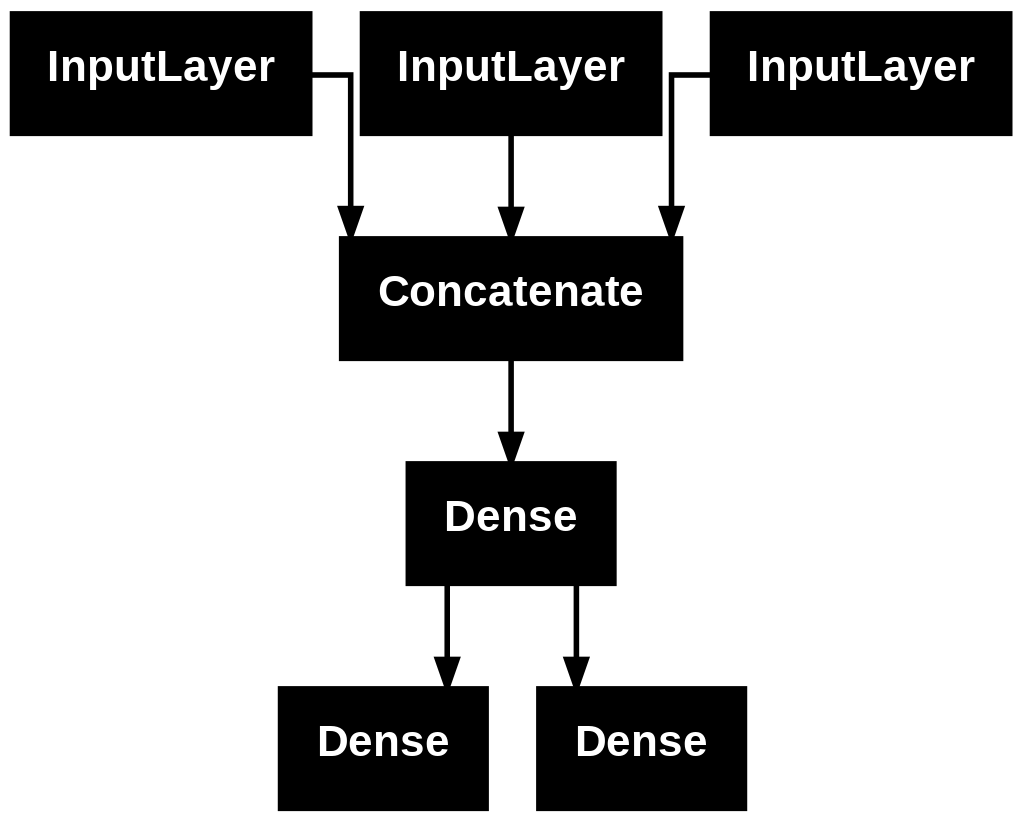

In [ ]:
keras.utils.plot_model(model, "ticket_classifier.png")

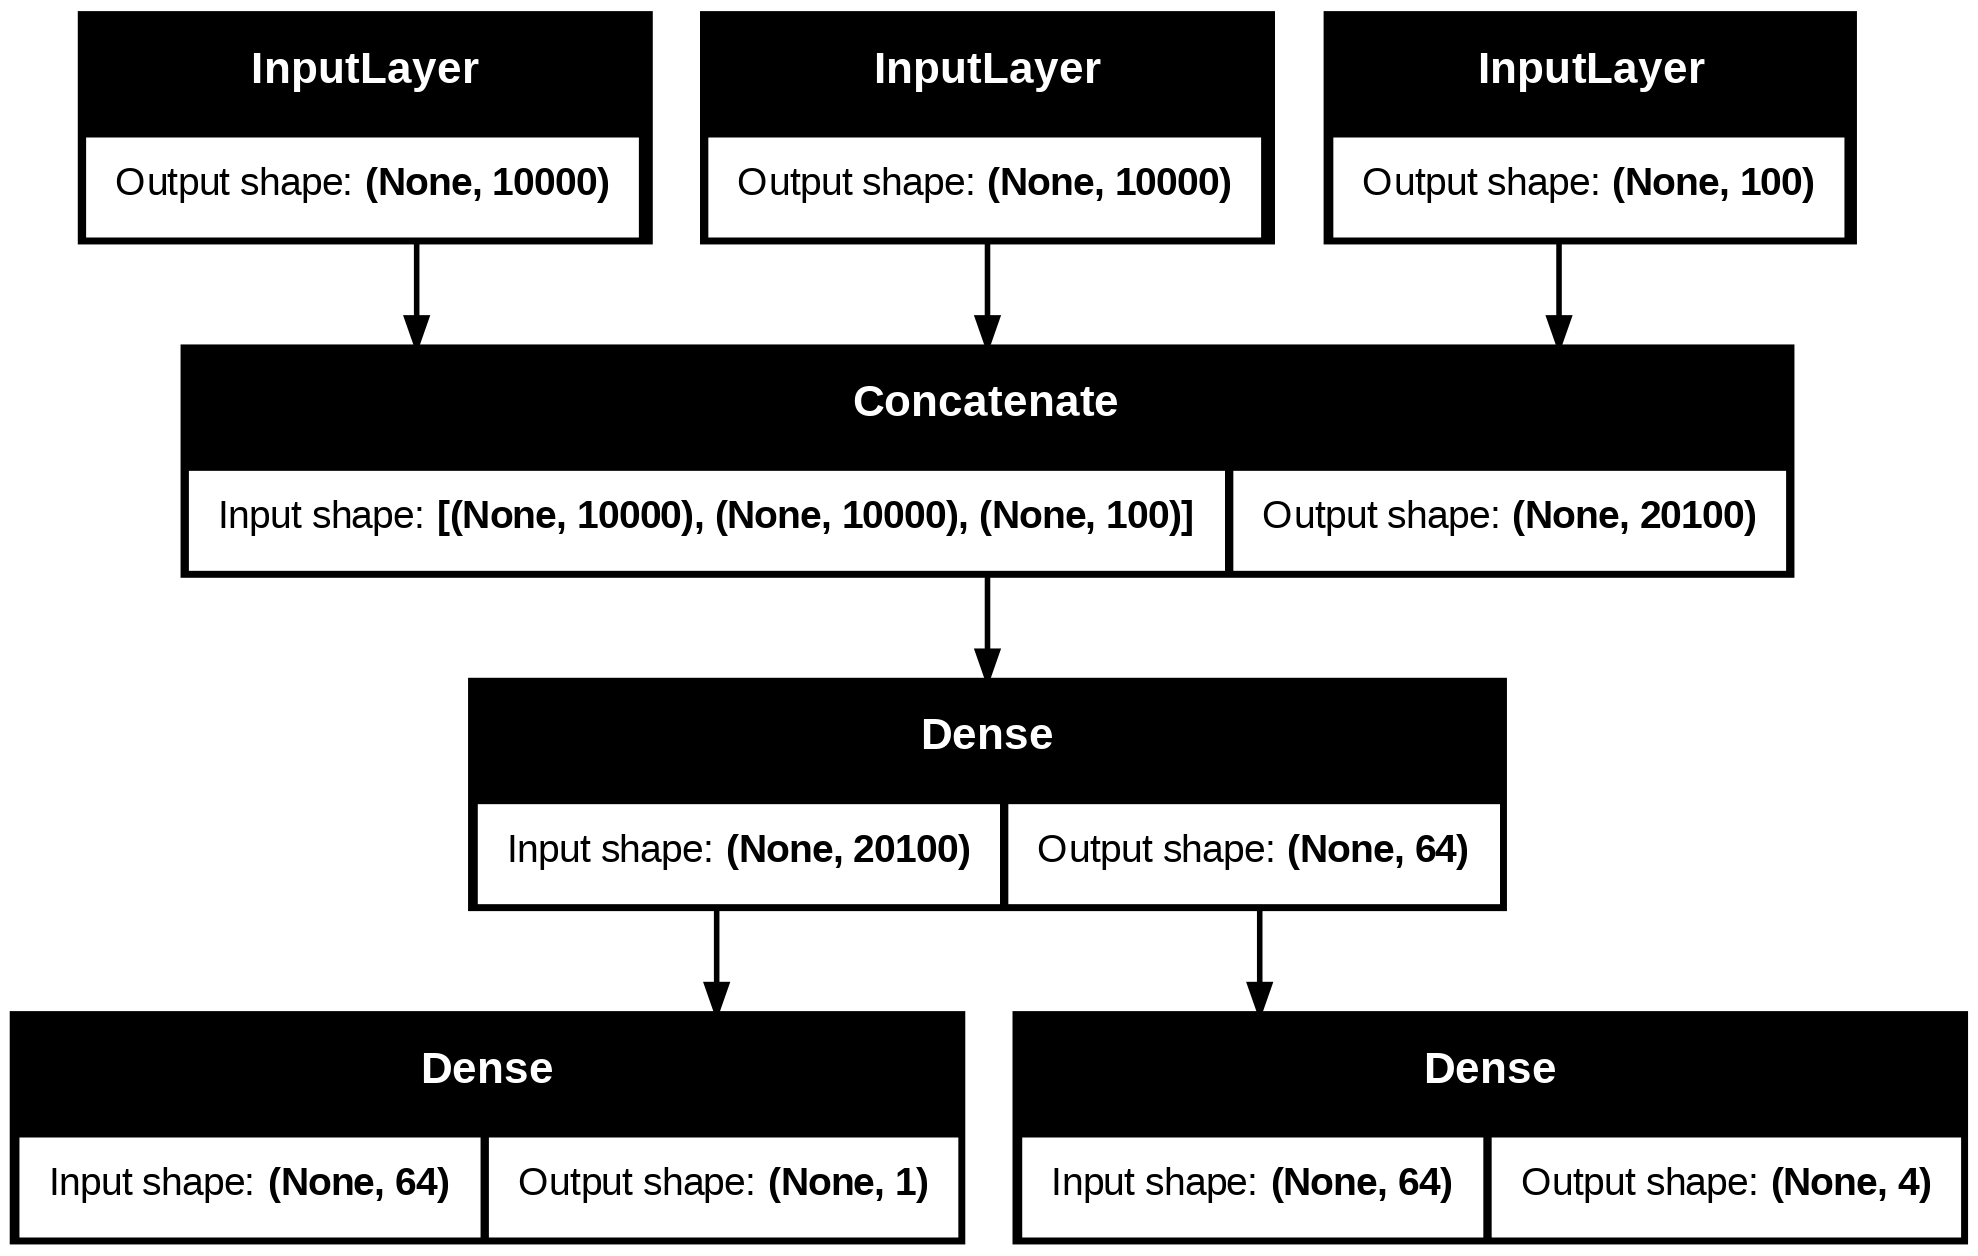

In [ ]:
keras.utils.plot_model(
 model, "ticket_classifier_with_shape_info.png", show_shapes=True)

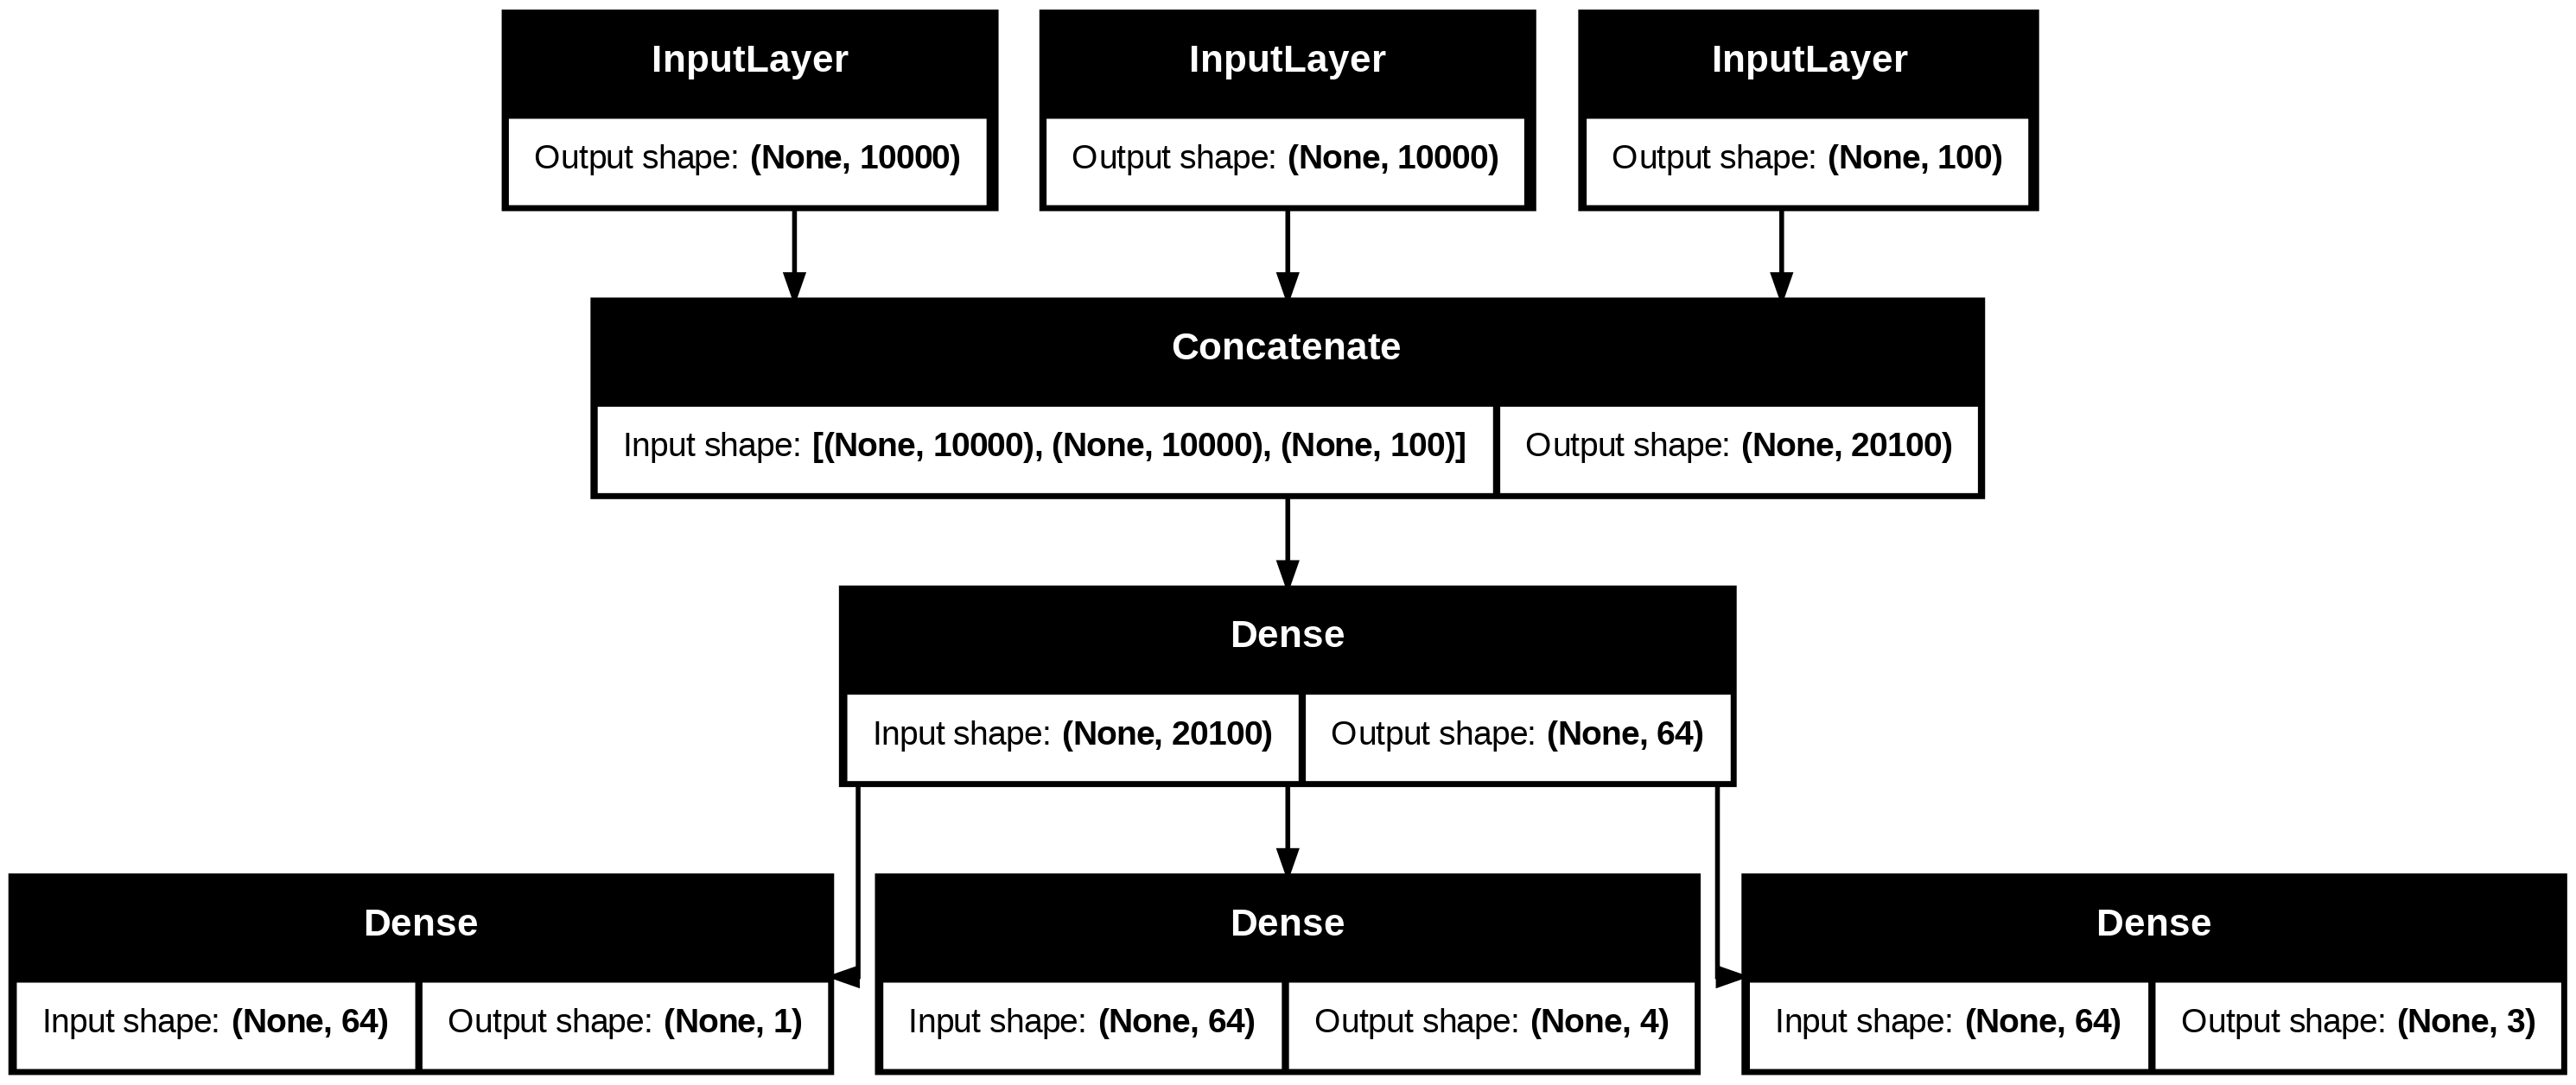

In [ ]:
# si ahora yo quiero concatenar una capa de salida extra, puedo reutilizar todo lo del modelo anterior:
features = model.layers[4].output # <-- esto es la primera capa dense es decir la capa oculta
# ahora esta capa está al nivel de las otras 2 de output
difficulty = layers.Dense(3, activation="softmax", name="difficulty")(features)

new_model = keras.Model(
 inputs=[title, text_body, tags],
 outputs=[priority, department, difficulty])

keras.utils.plot_model(
 new_model, "updated_ticket_classifier.png", show_shapes=True)

In [ ]:
# otra forma de crear modelos es crear clases (de OOP)
# todos los modelos tienen que heredar del modelo base que se llama
# keras.Model
class CustomerTicketModel(keras.Model):
  # como el tamaño del vocabulario es fijo realmente el único parámetro del que depende es el número de departamentos
  def __init__(self, num_departments): # esto es como el constructor de la clase
    super().__init__()
    self.concat_layer = layers.Concatenate() # capa de concatenar las capas de inputs
    self.mixing_layer = layers.Dense(64, activation="relu") # capa oculta intermedia
    self.priority_scorer = layers.Dense(1, activation="sigmoid") # primera capa output
    self.department_classifier = layers.Dense(num_departments, activation="softmax") # segunda capa output

  def call(self, inputs):
    # ahora, cuando yo use el objeto CustomerTicketModel construido con num_departments
    # y llame a esta función pasándole los inputs, qué sucede
    # inputs es un diccionario
    title = inputs["title"]
    text_body = inputs["text_body"]
    tags = inputs["tags"]
    # pues que se construyen las capas que son las propiedades del objeto
    features = self.concat_layer([title, text_body, tags])
    features = self.mixing_layer(features)
    priority = self.priority_scorer(features)
    department = self.department_classifier(features)
    # importante saber que call devuelve 2 elementos y como si fuera una lista,
    # se puede acceder con [0] y [1]
    return priority, department


In [ ]:
# instanciar el modelo lo crea vacío (sin pesos) porque se ha llamado
# al constructor __init__
model = CustomerTicketModel(num_departments=4)
# si le paso los datos de inputs, entonces por dentro se llama al método call(inputs)
priority, department = model(
    {"title": title_data, "text_body": text_body_data, "tags": tags_data})
# además, se entrena de forma igual que en funcional:
model.compile(optimizer="rmsprop",
              loss=["mean_squared_error", "categorical_crossentropy"],
              metrics=[["mean_absolute_error"], ["accuracy"]])
model.fit({"title": title_data,
          "text_body": text_body_data,
          "tags": tags_data},
          [priority_data, department_data],
          epochs=1)
model.evaluate({"title": title_data,
              "text_body": text_body_data,
              "tags": tags_data},
              [priority_data, department_data])
priority_preds, department_preds = model.predict({"title": title_data,
                                                "text_body": text_body_data,
                                                "tags": tags_data})

40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.2833 - loss: 27.1028 - mean_absolute_error: 0.4758
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.0609 - loss: 9.8565 - mean_absolute_error: 0.4967
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [ ]:
# creae tus propias métricas (todas tiene que heredar de keras.metrics.Metric):
class RootMeanSquaredError(keras.metrics.Metric):
  # constructor, que recibe el nombre
  def __init__(self, name="rmse", **kwargs):
    super().__init__(name=name, **kwargs)
    self.mse_sum = self.add_weight(name="mse_sum", initializer="zeros")
    self.total_samples = self.add_weight(
    name="total_samples", initializer="zeros", dtype="int32")

  def update_state(self, y_true, y_pred, sample_weight=None):
    # esto es: dado los parámetros y_true e y_pred, cuál es la pérdida
    y_true = tf.one_hot(y_true, depth=tf.shape(y_pred)[1])
    mse = tf.reduce_sum(tf.square(y_true - y_pred)) # <-- este es el mse
    self.mse_sum.assign_add(mse) # <-- lo acumulo (+=) sl que había
    num_samples = tf.shape(y_pred)[0]
    self.total_samples.assign_add(num_samples)

  def result(self): # valor actual del mse
    return tf.sqrt(self.mse_sum / tf.cast(self.total_samples, tf.float32))

  # resetear la métrica a 0 (cuando cambias de época o pasas de training a evaluation):
  def reset_state(self):
    self.mse_sum.assign(0.)
    self.total_samples.assign(0)

In [ ]:
# un callback es un objecto que se le pasa al fit(), que tiene acceso al estado interno del
# modelo y que en función de eso puede interrumpir el entrenamiento antes de tiempo, terminarlo y guardarlo, alterar el estado de hiperparámetros etc

# puedo construir mi propio método para train:
from tensorflow.keras.datasets import mnist
def get_mnist_model():
  inputs = keras.Input(shape=(28 * 28,))
  features = layers.Dense(512, activation="relu")(inputs)
  features = layers.Dropout(0.5)(features)
  outputs = layers.Dense(10, activation="softmax")(features)
  model = keras.Model(inputs, outputs)
  return model

model = get_mnist_model() # construyo el modelo vacío

# elijo la función de pérdida, el optimizer, las métricas a monitorizar
loss_fn = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.RMSprop()
metrics = [keras.metrics.SparseCategoricalAccuracy()]
# ahora cojo otra métrica (mean) que trackea la media de la función de pérdida
loss_tracking_metric = keras.metrics.Mean()

# ahora definir mi propio train es siempre igual:
def train_step(inputs, targets):
  with tf.GradientTape() as tape: # esto es el forward pass, "grabado" en el tape
    predictions = model(inputs, training=True)
    loss = loss_fn(targets, predictions)
  # esto es el backward pass
  gradients = tape.gradient(loss, model.trainable_weights)
  optimizer.apply_gradients(zip(gradients, model.trainable_weights))

  logs = {} # trackeo las métricas (SparseCategoricalAccuracy) y las actualizo
  for metric in metrics:
    metric.update_state(targets, predictions)
    logs[metric.name] = metric.result()

  loss_tracking_metric.update_state(loss) # trackeo y actualizo la loss_tracking_metric (el loss mean)
  logs["loss"] = loss_tracking_metric.result()
  return logs

def reset_metrics():
  for metric in metrics:
    metric.reset_state()
  loss_tracking_metric.reset_state()

# ahora puedo usar train_step y reset_metrics para runear mi propio método train:
(images, labels), (test_images, test_labels) = mnist.load_data()
images = images.reshape((60000, 28 * 28)).astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28)).astype("float32") / 255
train_images, val_images = images[10000:], images[:10000]
train_labels, val_labels = labels[10000:], labels[:10000]

training_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
training_dataset = training_dataset.batch(32)
epochs = 3
for epoch in range(epochs):
  reset_metrics()
  for inputs_batch, targets_batch in training_dataset:
    logs = train_step(inputs_batch, targets_batch)
    print(f"Results at the end of epoch {epoch}")
  for key, value in logs.items():
    print(f"...{key}: {value:.4f}")


Results at the end of epoch 0
Results at the end of epoch 0
Results at the end of epoch 0
Results at the end of epoch 0
Results at the end of epoch 0
Results at the end of epoch 0
Results at the end of epoch 0
Results at the end of epoch 0
Results at the end of epoch 0
Results at the end of epoch 0
Results at the end of epoch 0
Results at the end of epoch 0
Results at the end of epoch 0
Results at the end of epoch 0
Results at the end of epoch 0
Results at the end of epoch 0
Results at the end of epoch 0
Results at the end of epoch 0
Results at the end of epoch 0
Results at the end of epoch 0
Results at the end of epoch 0
Results at the end of epoch 0
Results at the end of epoch 0
Results at the end of epoch 0
Results at the end of epoch 0
Results at the end of epoch 0
Results at the end of epoch 0
Results at the end of epoch 0
Results at the end of epoch 0
Results at the end of epoch 0
Results at the end of epoch 0
Results at the end of epoch 0
Results at the end of epoch 0
Results at

KeyboardInterrupt: 

In [ ]:
metric = keras.metrics.SparseCategoricalAccuracy()
targets = [0, 1, 2]
predictions = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
metric.update_state(targets, predictions)
current_result = metric.result()
print(f"result: {current_result:.2f}")

values = [0, 1, 2, 3, 4]
mean_tracker = keras.metrics.Mean()
for value in values:
 mean_tracker.update_state(value)
print(f"Mean of values: {mean_tracker.result():.2f}")

In [ ]:
# REDES CONVOLUCIONALES, para tratamiento de imágenes, son un conjunto de capas Conv2D + MaxPool:
# creo un modelo vacío:
from tensorflow.keras.datasets import mnist
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(28, 28, 1)) # alto, ancho, canales
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
# a medida que se avanza en capas, el output es cada vez menos alto/ancho y más profundo
# finalmente se aplana con Flatten() para poder pasárselo a una densa que es el clasificador como tal
# entreno el modelo como siempre:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype("float32") / 255
model.compile(optimizer="rmsprop",
 loss="sparse_categorical_crossentropy",
 metrics=["accuracy"])
model.fit(train_images, train_labels, epochs=5, batch_size=64)

11490434/11490434 [==============================] - 0s 0us/step
Epoch 1/5
938/938 [==============================] - 9s 9ms/step - loss: 0.1637 - accuracy: 0.9491
Epoch 2/5
938/938 [==============================] - 8s 8ms/step - loss: 0.0444 - accuracy: 0.9861
Epoch 3/5
938/938 [==============================] - 8s 8ms/step - loss: 0.0305 - accuracy: 0.9903
Epoch 4/5
938/938 [==============================] - 8s 8ms/step - loss: 0.0227 - accuracy: 0.9927
Epoch 5/5
938/938 [==============================] - 8s 8ms/step - loss: 0.0180 - accuracy: 0.9945


In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_acc:.3f}")

313/313 [==============================] - 1s 3ms/step - loss: 0.0241 - accuracy: 0.9921
Test accuracy: 0.992


In [ ]:
!rm -rf test1.zip
!rm -rf train.zip

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pablocaballeromara","key":"a5e4d65fd387dfa9c1aa2cbc48a19bf2"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!kaggle competitions download -c dogs-vs-cats


 99% 804M/812M [00:09<00:00, 69.7MB/s]
100% 812M/812M [00:09<00:00, 89.5MB/s]


In [ ]:
!unzip -qq dogs-vs-cats.zip

In [ ]:
!unzip -qq train.zip

In [ ]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
  for category in ("cat", "dog"):
    dir = new_base_dir / subset_name / category
    os.makedirs(dir)
    fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
    for fname in fnames:
      shutil.copyfile(src=original_dir / fname, dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
# pasar las imágenes al rango [0,1]
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.compile(loss="binary_crossentropy",
 optimizer="rmsprop",
 metrics=["accuracy"])

In [ ]:
# PREPROCESAR LAS IMÁGENES:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
 new_base_dir / "train",
 image_size=(180, 180),
 batch_size=32)
validation_dataset = image_dataset_from_directory(
 new_base_dir / "validation",
 image_size=(180, 180),
 batch_size=32)
test_dataset = image_dataset_from_directory(
 new_base_dir / "test",
 image_size=(180, 180),
 batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [ ]:
for data_batch, labels_batch in train_dataset:
  print("data batch shape:", data_batch.shape)
  print("labels batch shape:", labels_batch.shape)
  break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


In [ ]:
# a la hora de entrenar mi modelo, al fit le paso un callback para que solo
# sobreescriba el que ya tengo si es mejor:
callbacks = [
 keras.callbacks.ModelCheckpoint(
 filepath="convnet_from_scratch.keras",
 save_best_only=True,
 monitor="val_loss") # esto es la cosa que tiene que mejorar para que el modelo sea "mejor"
]

history = model.fit(
 train_dataset,
 epochs=30,
 validation_data=validation_dataset,
 callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 18s 273ms/step - loss: 0.7002 - accuracy: 0.4985 - val_loss: 0.6915 - val_accuracy: 0.5860
Epoch 2/30
63/63 [==============================] - 17s 270ms/step - loss: 0.6944 - accuracy: 0.5190 - val_loss: 0.6914 - val_accuracy: 0.5010
Epoch 3/30
63/63 [==============================] - 17s 268ms/step - loss: 0.6850 - accuracy: 0.5645 - val_loss: 0.6932 - val_accuracy: 0.5400
Epoch 4/30
63/63 [==============================] - 17s 265ms/step - loss: 0.6635 - accuracy: 0.5985 - val_loss: 0.6269 - val_accuracy: 0.6510
Epoch 5/30
63/63 [==============================] - 16s 257ms/step - loss: 0.6309 - accuracy: 0.6430 - val_loss: 0.6362 - val_accuracy: 0.6530
Epoch 6/30
63/63 [==============================] - 16s 258ms/step - loss: 0.6134 - accuracy: 0.6480 - val_loss: 0.6183 - val_accuracy: 0.6410
Epoch 7/30
63/63 [==============================] - 16s 259ms/step - loss: 0.5712 - accuracy: 0.7035 - val_loss: 0.5817 - val_accuracy: 0.6860

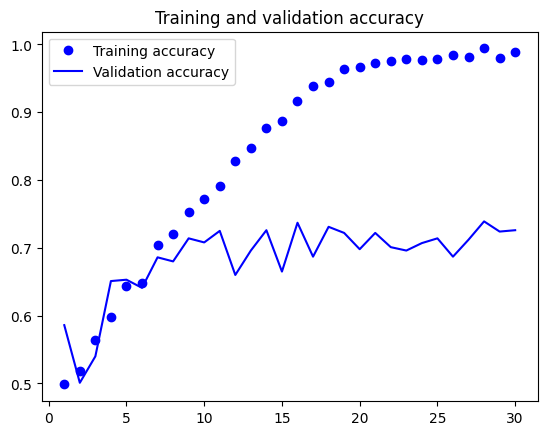

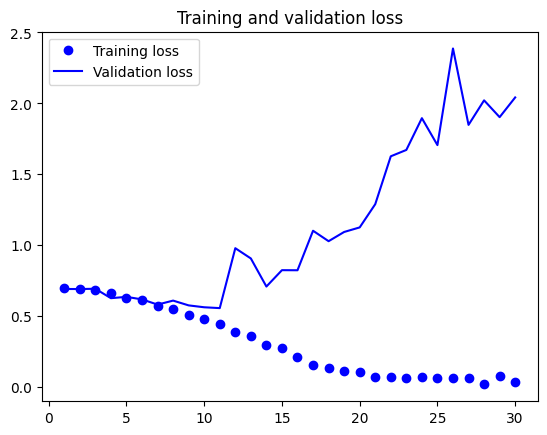

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
# para usar técnicas de data augmentation tengo que construir un modelo entero
# que luego meto en la ConvNet como si fuera una CAPA. para construir este modelo
# hay capas de transformaciones que ya existen (al final una transformación afín es multiplicar una matriz que es la imagen por otra matriz
# que es la transformación)
data_augmentation = keras.Sequential(
 [
 layers.RandomFlip("horizontal"),
 layers.RandomRotation(0.1),
 layers.RandomZoom(0.2),
 ]
)

inputs = keras.Input(shape=(180, 180, 3))
# esta "capa" (compuesta de 3 capas) transforma las imágenes
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(loss="binary_crossentropy",
 optimizer="rmsprop",
 metrics=["accuracy"])

In [ ]:
callbacks = [
 keras.callbacks.ModelCheckpoint(
 filepath="convnet_from_scratch_with_augmentation.keras",
 save_best_only=True,
 monitor="val_loss")
]
history = model.fit(
 train_dataset,
 epochs=100,
 validation_data=validation_dataset,
 callbacks=callbacks)

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 213s 3s/step - accuracy: 0.5222 - loss: 0.7056 - val_accuracy: 0.5000 - val_loss: 0.6927
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 251s 3s/step - accuracy: 0.4943 - loss: 0.6951 - val_accuracy: 0.5000 - val_loss: 0.7076
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 205s 3s/step - accuracy: 0.5241 - loss: 0.6994 - val_accuracy: 0.5120 - val_loss: 0.6895
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 199s 3s/step - accuracy: 0.5588 - loss: 0.6851 - val_accuracy: 0.5000 - val_loss: 1.0381
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 219s 3s/step - accuracy: 0.6058 - loss: 0.6789 - val_accuracy: 0.5980 - val_loss: 0.6538
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 203s 3s/step - accuracy: 0.6117 - loss: 0.6743 - val_accuracy: 0.5800 - val_loss: 0.7475
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 259s 3s/step - accuracy: 0.6619 - loss: 0.6364 - val_accuracy: 0.6100 - val_loss: 0.6311
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 199s 3s/step - accuracy: 0.6719 - loss: 0.6068 - val_accuracy: 0.